## Evaluation of diffusion model against benchmarks

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import xskillscore as xss
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import spearmanr, pearsonr
from read_data import get_cond_ecmwf_dataset, get_mean_std_data
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

2024-03-29 13:45:10.808809: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-29 13:45:10.865837: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-29 13:45:10.866762: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-29 13:45:12.381264: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


**Utils**

In [14]:
def plot_eval_metrics(rmse, mae, r2, pearson, spearman):
    fig, axs = plt.subplots(5, 3, figsize=(12, 12))

    # RMSE
    axs[0, 0].imshow(rmse['bilint'])
    axs[0, 1].imshow(rmse['qm'])
    im = axs[0, 2].imshow(rmse['diffusion'])
    fig.colorbar(im, ax=axs[0, :])
    axs[0, 0].set(ylabel='RMSE')

    # MAE
    axs[1, 0].imshow(mae['bilint'])
    axs[1, 1].imshow(mae['qm'])
    im = axs[1, 2].imshow(mae['diffusion'])
    fig.colorbar(im, ax=axs[1, :])
    axs[1, 0].set(ylabel='MAE')

    # R2
    axs[2, 0].imshow(r2['bilint'])
    axs[2, 1].imshow(r2['qm'])
    im = axs[2, 2].imshow(r2['diffusion'])
    fig.colorbar(im, ax=axs[2, :])
    axs[2, 0].set(ylabel='R2')

    # PEARSON
    axs[3, 0].imshow(pearson['bilint'])
    axs[3, 1].imshow(pearson['qm'])
    im = axs[3, 2].imshow(pearson['diffusion'])
    fig.colorbar(im, ax=axs[3, :])
    axs[3, 0].set(ylabel='Pearson')

    # SPEARMAN
    axs[4, 0].imshow(spearman['bilint'])
    axs[4, 1].imshow(spearman['qm'])
    im = axs[4, 2].imshow(spearman['diffusion'])
    fig.colorbar(im, ax=axs[4, :])
    axs[4, 0].set(ylabel='Spearman')

    # Define column names
    axs[0, 0].set_title('Bilinear interpolation')
    axs[0, 1].set_title('Quantile Mapping')
    axs[0, 2].set_title('Diffusion')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

In [16]:
def display_metrics_table(rmse, mae, r2, pearson, spearman):
    df_metrics = pd.DataFrame(
        data=np.array([
            [np.mean(rmse['bilint']), np.mean(rmse['qm']), np.mean(rmse['diffusion'])],
            [np.mean(mae['bilint']), np.mean(mae['qm']), np.mean(mae['diffusion'])],
            [np.mean(np.abs(r2['bilint'])), np.mean(np.abs(r2['qm'])), np.mean(np.abs(r2['diffusion']))],
            [np.mean(np.abs(pearson['bilint'])), np.mean(np.abs(pearson['qm'])), np.mean(np.abs(pearson['diffusion']))],
            [np.mean(np.abs(spearman['bilint'])), np.mean(np.abs(spearman['qm'])), np.mean(np.abs(spearman['diffusion']))],
        ]),
        index=['RMSE', 'MAE', 'R2', 'Pearson', 'Spearman'],
        columns=['Bilinear', 'Quantile Mapping', 'Diffusion'],
    )
    display(df_metrics)

**Read forecasts and chirps** 

In [3]:
ecmwf = xr.open_mfdataset('data/test/*.zarr').ecmwf.load()
chirps = xr.open_mfdataset('data/test/*.zarr').chirps.load()

/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-pa

**Read benchmarks** 

In [5]:
qm = xr.open_zarr('data/benchmarks_results/QM/test_quantile_mapping.zarr').scen.load()
climax = xr.open_zarr('data/benchmarks_results/ClimaX/test_climax.zarr')
bilint = xr.open_zarr('data/benchmarks_results/bilinear/test_bilinear.zarr').bilint.load()

**Compute metrics**

In [6]:
### Benchmarks
rmse, mae, r2, pearson, spearman = dict(), dict(), dict(), dict(), dict()

rmse['qm'] = xss.rmse(qm, chirps, dim='time')
rmse['bilint'] = xss.rmse(bilint, chirps, dim='time')

mae['qm'] = xss.mae(qm, chirps, dim='time')
mae['bilint'] = xss.mae(bilint, chirps, dim='time')

r2['qm'] = xss.r2(qm, chirps, dim='time')
r2['bilint'] = xss.r2(bilint, chirps, dim='time')

pearson['qm'] = xss.pearson_r(qm, chirps, dim='time')
pearson['bilint'] = xss.pearson_r(bilint, chirps, dim='time')

spearman['qm'] = xss.spearman_r(qm, chirps, dim='time')
spearman['bilint'] = xss.spearman_r(bilint, chirps, dim='time')

In [7]:
### Get mean and var for de-normalizing
mean_chirps, var_chirps, mean_ecmwf, var_ecmwf = get_mean_std_data(split="train")

In [8]:
### Evaluate diffusion model with simple metrics
batch_test = next(iter(get_cond_ecmwf_dataset(split="test", batch_size=ecmwf.time.size)))

test_batch_cond = batch_test["cond"]['channel:low_res']
test_batch_gt = batch_test["x"]

xx = np.load(f"data/diffusion/batch_25samples.npy")

rmse['diffusion'], mae['diffusion'], r2['diffusion'], pearson['diffusion'], spearman['diffusion'] = np.zeros((28, 28)), np.zeros((28, 28)), np.zeros((28, 28)), np.zeros((28, 28)), np.zeros((28, 28))

for i in range(test_batch_cond.shape[1]):
    for j in range(test_batch_cond.shape[2]):
        pred = np.mean(xx, axis=1)[:, i, j, 0]  * (var_chirps + 1e-4) + mean_chirps
        ground_truth = test_batch_gt[:, i, j, 0]  * (var_chirps + 1e-4) + mean_chirps
        
        rmse['diffusion'][i, j] = root_mean_squared_error(ground_truth, pred)
        mae['diffusion'][i, j] = mean_absolute_error(ground_truth, pred)
        r2['diffusion'][i, j] = r2_score(ground_truth, pred)
        pearson['diffusion'][i, j] = pearsonr(ground_truth, pred).statistic
        spearman['diffusion'][i, j] = spearmanr(ground_truth, pred).statistic

2024-03-29 13:45:45.837386: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


**Plot simple metrics**

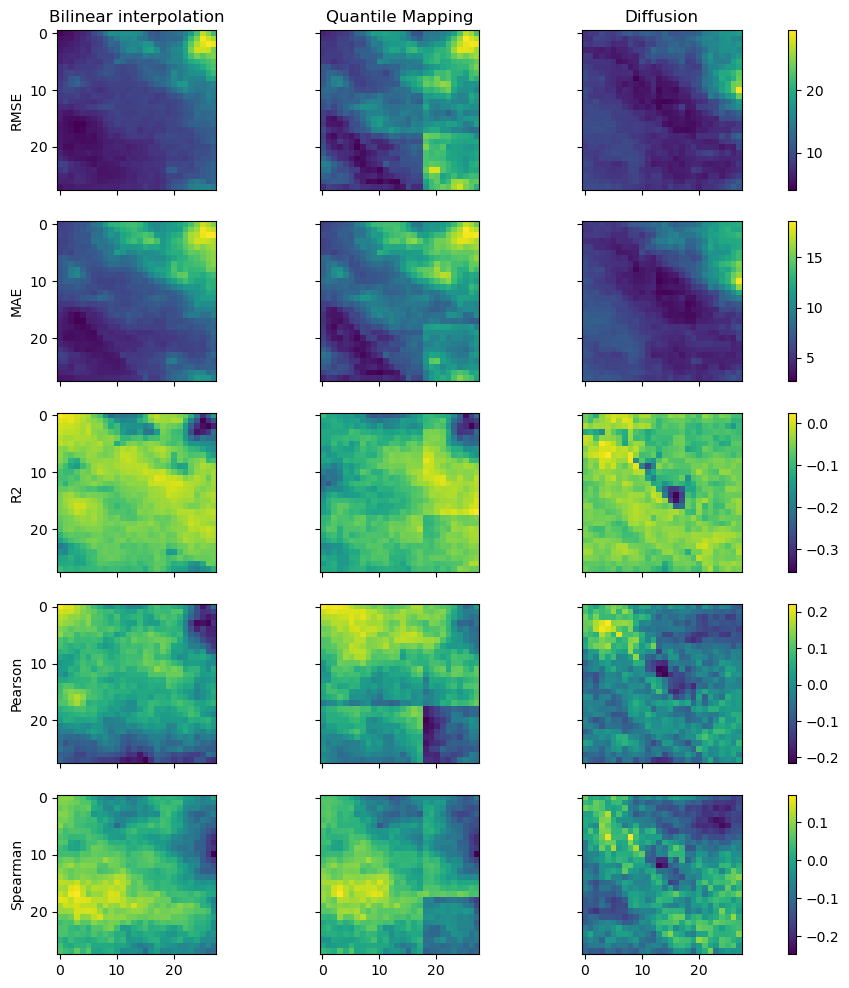

In [15]:
plot_eval_metrics(rmse, mae, r2, pearson, spearman)

In [17]:
display_metrics_table(rmse, mae, r2, pearson, spearman)

,Bilinear,Quantile Mapping,Diffusion
RMSE,41.730533,42.135738,9.167076
MAE,26.132520,25.652172,6.253671
R2,0.238383,0.151149,0.064802
Pearson,0.593546,0.558478,0.055073
Spearman,0.730577,0.719076,0.069428


In [1]:
#fig, ax1, ax2, ax3 = plt.subplots(1, 3, figsize=(3, 9))


#ax1.hist((forecast.isel(time=t, ensemble=member) - gt.isel(time=t, ensemble=member)).values.ravel(), bins=50, color='b', alpha=0.7)


RAJOUTER LE HISTOGRAMME POUR CHAQUE METHODE (KDE PLOT SUR SEABORN)

**Compare SPI** 

In [37]:
spi_diffusion = xr.open_zarr('data/diffusion/test_diffusion_spi.zarr').__xarray_dataarray_variable__ / 1000
spi_bilint = xr.open_zarr('data/benchmarks_results/bilinear/test_bilint_spi.zarr').tp / 1000
spi_qm = xr.open_zarr('data/benchmarks_results/QM/test_qm_spi.zarr').scen / 1000

spi_gt = xr.open_zarr('data/test_spi_chirps.zarr').chirps / 1000

In [38]:
# Compute metrics on SPI
rmse_spi, mae_spi, r2_spi, pearson_spi, spearman_spi = dict(), dict(), dict(), dict(), dict()

rmse_spi['diffusion'] = xss.rmse(spi_diffusion, spi_gt, dim='time')
rmse_spi['qm'] = xss.rmse(spi_qm, spi_gt, dim='time')
rmse_spi['bilint'] = xss.rmse(spi_bilint, spi_gt, dim='time')

mae_spi['diffusion'] = xss.mae(spi_diffusion, spi_gt, dim='time')
mae_spi['qm'] = xss.mae(spi_qm, spi_gt, dim='time')
mae_spi['bilint'] = xss.mae(spi_bilint, spi_gt, dim='time')

r2_spi['diffusion'] = xss.r2(spi_diffusion, spi_gt, dim='time')
r2_spi['qm'] = xss.r2(spi_qm, spi_gt, dim='time')
r2_spi['bilint'] = xss.r2(spi_bilint, spi_gt, dim='time')

pearson_spi['diffusion'] = xss.pearson_r(spi_diffusion, spi_gt, dim='time')
pearson_spi['qm'] = xss.pearson_r(spi_qm, spi_gt, dim='time')
pearson_spi['bilint'] = xss.pearson_r(spi_bilint, spi_gt, dim='time')

spearman_spi['diffusion'] = xss.spearman_r(spi_diffusion, spi_gt, dim='time')
spearman_spi['qm'] = xss.spearman_r(spi_qm, spi_gt, dim='time')
spearman_spi['bilint'] = xss.spearman_r(spi_bilint, spi_gt, dim='time')

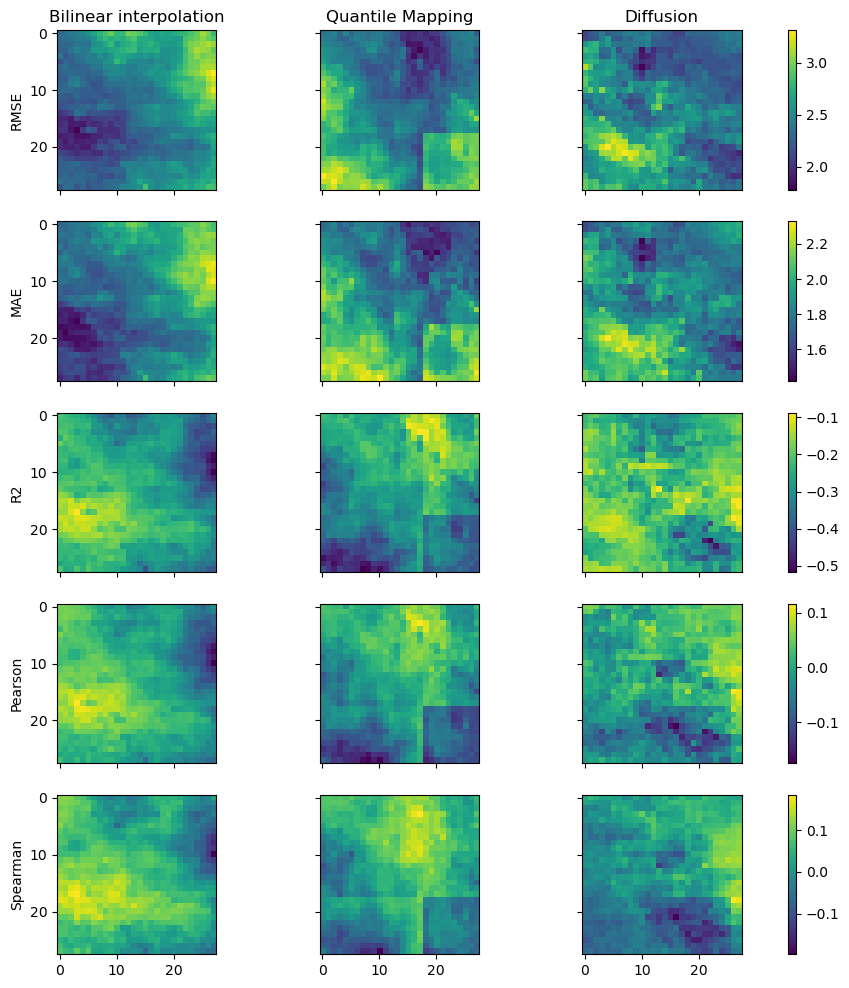

In [39]:
# Plot
plot_eval_metrics(rmse_spi, mae_spi, r2_spi, pearson_spi, spearman_spi)

In [40]:
display_metrics_table(rmse_spi, mae_spi, r2_spi, pearson_spi, spearman_spi)

,Bilinear,Quantile Mapping,Diffusion
RMSE,0.796008,0.789744,2.464268
MAE,0.627095,0.602166,1.873394
R2,0.467875,0.432512,0.223715
Pearson,0.721156,0.710485,0.040541
Spearman,0.730576,0.719083,0.052161


**Compare drought outcome (SPI<t)** 

In [42]:
DROUGHT_THRESHOLD = -1.

In [47]:
outcome_diffusion = (xr.open_zarr('data/diffusion/test_diffusion_spi.zarr').__xarray_dataarray_variable__ / 1000 < DROUGHT_THRESHOLD).astype(int)
outcome_bilint = (xr.open_zarr('data/benchmarks_results/bilinear/test_bilint_spi.zarr').tp / 1000 < DROUGHT_THRESHOLD).astype(int)
outcome_qm = (xr.open_zarr('data/benchmarks_results/QM/test_qm_spi.zarr').scen / 1000 < DROUGHT_THRESHOLD).astype(int)

outcome_gt = (xr.open_zarr('data/test_spi_chirps.zarr').chirps / 1000 < DROUGHT_THRESHOLD).astype(int)

In [48]:
# Compute roc score
roc_score = dict()

roc_score['diffusion'] = xss.roc(outcome_gt, outcome_diffusion, dim='time', return_results="area")
roc_score['qm'] = xss.roc(outcome_gt, outcome_qm, dim='time', return_results="area")
roc_score['bilint'] = xss.roc(outcome_gt, outcome_bilint, dim='time', return_results="area")

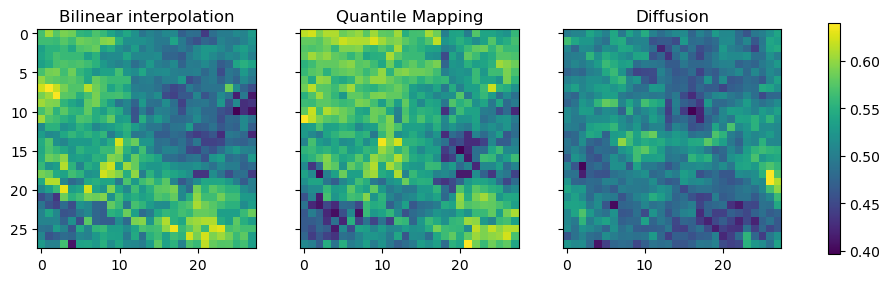

In [57]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))

ax1.imshow(roc_score['bilint'].values)
ax1.set_title('Bilinear interpolation')
ax1.label_outer()

ax2.imshow(roc_score['qm'].values)
ax2.set_title('Quantile Mapping')
ax2.label_outer()

im = ax3.imshow(roc_score['diffusion'].values)
ax3.set_title('Diffusion')
ax3.label_outer()

fig.colorbar(im, ax=(ax1, ax2, ax3))

In [58]:
pd.DataFrame(
    data=np.array([[np.mean(roc_score['bilint']), np.mean(roc_score['qm']), np.mean(roc_score['diffusion'])]]),
    index=['ROC score'],
    columns=['Bilinear', 'Quantile Mapping', 'Diffusion'],
)

,Bilinear,Quantile Mapping,Diffusion
ROC score,0.720532,0.737084,0.498737
